In [1]:
from datastructures.polycasebuilder import generate_random_polynomials, get_arg_mapping, directed_poly_executables, eqv_to_edges_tree
from testproblems import generate_random_prob
from datastructures.graphutils import VAR, COMP, SOLVER, edges_to_Ein_Eout, sinks, sources, namefromid, all_components, nested_sources, path
from datastructures.nestedgraph import root_sources
from datastructures.workflow import OBJ, NEQ, EQ, OPT
from datastructures.runpipeline import nestedform_to_mdao
import numpy as np
from datastructures.execution import Component
from datastructures.operators import sort_scc, reorder_merge_solve
from representations import bipartite_repr
from inputresolver import getallvars, direct_eqs, invert_edges
from datastructures.tearing import min_max_scc, outset_from_solution
from compute import Var
import openmdao.api as om
import pandas as pd
from functools import partial
from collections import defaultdict
import time
from ipywidgets import IntProgress
from IPython.display import display

In [2]:
from numpy import random

In [3]:
nodetyperepr = {VAR: 'x_{{{}}}', COMP: 'f_{}', SOLVER: 's_{}'}
namefunc = namefromid(nodetyperepr)

In [4]:
def generate_var(varids):
    return [Var(namefunc(varid, VAR)) for varid in varids]

In [5]:
#(5,10,7,1.7 no numerical issues)
n_eqs = 5
n_vars = 10
seed = 9#8 is triang#seed 10 is nice 42 
sparsity = 1.7#0.8 1.1 #1.7 1.3
eqv, varinc, output_set = generate_random_prob(n_eqs, n_vars, seed, sparsity)
#polynomials, var_mapping, edges, tree, components = generate_random_polynomials(eqv, output_set, n_eqs)

In [6]:
eqv

{0: (5, 6, 7, 10, 11, 12),
 1: (6, 7, 9, 11, 12, 13, 5),
 2: (5, 6, 8, 9, 10, 11, 12),
 3: (6, 8, 11, 12, 14),
 4: (5, 6, 8, 10, 11, 12, 13, 14, 7)}

In [7]:
def optimal_formulation(eqv, output_set):
    n_eqs = len(eqv)
    _, edges_original = bipartite_repr(eqv)
    eqs=direct_eqs(eqv, output_set)
    avrs = getallvars(eqs, sympy=False)
    eqns = eqs.keys()
    graph_edges = invert_edges(edges_original)
    maxl, xsol, m = min_max_scc(graph_edges, avrs, eqns)
    best_outset = dict(outset_from_solution(m))
    return best_outset

In [8]:
def generate(g, limit=2):
    def generator(*args):
        for i in range(limit):
            for elt in g(*args):
                yield elt
    return generator

In [9]:
rng1 = np.random.default_rng(0);
rng2 = np.random.default_rng(1);

In [10]:
def g1(m,n,c,eqvs=None,outsets=None,randstruct=None):
    s = int(rng1.integers(0, 2**16))
    randstruct[(m,n,c)].append(s)
    eqv, _, output_set = generate_random_prob(m, n, s, c)
    output_set_opt = optimal_formulation(eqv, output_set)
    eqvs[(m,n,c,s)] = eqv
    outsets[(m,n,c,s,1)] = output_set
    outsets[(m,n,c,s,2)] = output_set_opt
    yield (m, n, c, s)

In [11]:
def g2(m, n, c, s, randpoly=None):
    r = int(rng2.integers(0, 2**31)) 
    randpoly[(m,n,c,s)].append(r)
    yield (m, n, c, s, 1, r)
    yield (m, n, c, s, 2, r)

In [12]:
def g3(*args):
    yield tuple(args) + (True,)
    yield tuple(args) + (False,)

In [13]:
outsets = dict()
eqvs = dict()
randstruct = defaultdict(list)
randpoly = defaultdict(list)

In [14]:
funtable = {
    1: (generate(partial(g1, eqvs=eqvs,outsets=outsets, randstruct=randstruct), limit=10), 2),
    2: (generate(partial(g2, randpoly=randpoly), limit=10), 3),
    3: (g3, None)
}

In [15]:
q = [(1, (10, 15, 1))]
output = []
while q:
    fid, args = q.pop()
    if fid:
        f, nextfid  = funtable[fid]
        for elt in f(*args):
            q.append((nextfid,elt))
    else:
        output.append(args)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [16]:
def add_obj(inputids, var_mapping, edges, tree, components):
    inputvars = [var_mapping[elt][0] for elt in inputids]
    fobj = sum([(elt-1)**2 for elt in inputvars])
    newidx = 'obj'#len(edges[1])
    c = Component.fromsympy(fobj, component=newidx, arg_mapping=var_mapping)
    edges[0][newidx] = c.inputs
    edges[1][newidx] = c.outputs
    tree[0][newidx] = 1
    return components+[c], newidx

In [17]:
def generate_mdao_prob(inputids, var_mapping, edges, tree, components, mdf=True):
    components, newidx = add_obj(inputids, var_mapping, edges, tree, components)
    solvers_options = {1: {'type': OPT, 'disp':False}, 2:{'maxiter':200}}
    comp_options = {newidx:OBJ}
    dv = root_sources(edges, tree)
    for elt in dv:
        tree[2][elt] = 1
    var_options = {}
    nodetyperepr = {VAR: 'x_{}', COMP: 'f_{}', SOLVER: 's_{}'}
    prob, mdao_in, groups, formulation,merge_order = nestedform_to_mdao(edges, tree, components, solvers_options, comp_options, var_options, nodetyperepr, mdf)
    return prob, groups, formulation, merge_order

In [18]:
def get_mdaoprobargs(outsets, eqvs, m, n, c, r1, M, r2, mdf):
    outset = outsets[(m,n,c,r1,M)]
    eqv = eqvs[(m,n,c,r1)]
    n_eqs = len(eqv)
    rng = np.random.default_rng(r2)
    _, var_mapping, edges, tree, components = generate_random_polynomials(eqv, outset, n_eqs, rng)
    inputids = sources(*edges_to_Ein_Eout(edges))
    return inputids, var_mapping, edges, tree, components

In [19]:
def generate_prob(outsets, eqvs, m, n, c, r1, M, r2, mdf):
    inputids, var_mapping, edges, tree, components = get_mdaoprobargs(outsets, eqvs, m, n, c, r1, M, r2, mdf)
    prob, groups, formulation,merge_order = generate_mdao_prob(inputids, var_mapping, edges, tree, components, mdf)
    scc = [len(elt) for elt in merge_order if len(elt)>1]
    try:
        prob.set_solver_print(-1)
        tic = time.perf_counter()
        prob.run_driver()
        toc = time.perf_counter()
        Stree=formulation[1][1]
        total_iters = 0
        for key,var in Stree.items():
            parent = groups['s_{}'.format(var)]
            total_iters += getattr(parent, 's_{}'.format(key)).iter_count_apply
        objiter = groups['s_1'].f_obj.iter_count
        return prob.driver.result.fun, total_iters, objiter, scc, toc-tic
    except:
        return 9999, None, None, scc, None

In [ ]:
def measure_optimization(prob, groups, Stree):
    try:
        prob.set_solver_print(-1)
        tic = time.perf_counter()
        prob.run_driver()
        toc = time.perf_counter()
        total_iters = 0
        for key,var in Stree.items():
            parent = groups['s_{}'.format(var)]
            total_iters += getattr(parent, 's_{}'.format(key)).iter_count_apply
        objiter = groups['s_1'].f_obj.iter_count
        return prob.driver.result.fun, total_iters, objiter, scc, toc-tic
    except:
        return 9999, None, None, scc, None

In [ ]:
def min_max_scc_calculations(eq_incidence=None, edges_varonleft=None, varidxs=None, eqnidxs=None, outset=None, probtype=None, seed_poly=None, mdf=None, **kwargs):
    if probtype == 2:
        xsol, m = min_max_scc2(edges_varonleft, varidxs, eqnidxs, timeout=100)
        if xsol:
            outset = tuple((right, left) for left, right in edges_varonleft if xsol[left, right] > 0.5)
            D = nx.DiGraph(dir_graph(edges_varonleft, eqnidxs, output_set_opt))
            minssc = max(len(elt) for elt in nx.strongly_connected_components(D))//2
            minssc = max(minssc,0)
        else:
            minssc = 999
    rng = np.random.default_rng(seed_poly)
    _, var_mapping, edges, tree, components = generate_random_polynomials(eq_incidence, outset, len(eqnidxs), rng)
    inputids = sources(*edges_to_Ein_Eout(edges))
    prob, groups, formulation,merge_order = generate_mdao_prob(inputids, var_mapping, edges, tree, components, mdf)
    return measure_optimization(prob, groups, formulation[1][1])

In [ ]:
fxs = {('fobj', 'solveriter', 'optiter', 'maxscc', 'time'): min_max_scc_calculations}

In [ ]:
def generate_artifacts(m,n,sparsity,seed,probtype,seed_poly,mdf):
    kwargs = random_problem_with_artifacts(m,n,seed,sparsity)
    kwargs.update({
        "seed_poly": seed_poly,
        "probtype": probtype,
        "mdf": mdf
    })
    return kwargs

In [ ]:
run_calculations(df, fxs, iter_cycles=None, filename=None, 
                 commonartifacts=generate_artifacts, argnames=["m", "n", "sparsity", "seed", "probtype", "seed_poly", "mdf"])

In [20]:
df = pd.DataFrame(output)
df.set_axis(['m', 'n', 'c', 'r1', 'M', 'r2', 'mdf'], axis=1, inplace=True)

In [21]:
len(df)

400

# Debuging

In [76]:
elt = df.iloc[104]
kwargs = {key:var for key,var in elt.items() if key not in ['fobj', 'niter', 'scc']}

In [54]:
kwargs

{'m': 10, 'n': 15, 'c': 1, 'r1': 1083, 'M': 2, 'r2': 1155653965, 'mdf': False}

In [55]:
inputids, var_mapping, edges, tree, components = get_mdaoprobargs(outsets, eqvs, **kwargs)
mdf = kwargs['mdf']

In [56]:
components, newidx = add_obj(inputids, var_mapping, edges, tree, components)
solvers_options = {1: {'type': OPT, 'disp':True}, 2:{'maxiter':200}}
comp_options = {newidx:OBJ}
dv = root_sources(edges, tree)
for elt in dv:
    tree[2][elt] = 1
var_options = {}
nodetyperepr = {VAR: 'x_{}', COMP: 'f_{}', SOLVER: 's_{}'}

In [57]:
from datastructures.nestedgraph import flat_graph_formulation
from datastructures.graphutils import root_solver

In [58]:
G = flat_graph_formulation(*edges)
merge_order = sort_scc(G)
merge_parent = root_solver(tree) # all merged components will have this solver as the parent
ordered_edges, ordered_tree = reorder_merge_solve(edges, tree, merge_order, merge_parent, mdf)

In [59]:
from datastructures.workflow import order_from_tree, default_solver_options, mdao_workflow, get_f
from datastructures.execution import generate_components_and_residuals
from datastructures.workflow_mdao import mdao_workflow_with_args
from datastructures.assembly import build_archi

In [60]:
namingfunc = namefromid(nodetyperepr)
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)
all_components = generate_components_and_residuals(components, ordered_edges)
lookup_f = get_f(all_components, ordered_edges)

In [61]:
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)

In [62]:
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc)

In [63]:
prob.run_driver();

Optimization terminated successfully    (Exit mode 0)
            Current function value: [0.]
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2
Optimization Complete
-----------------------------------


In [66]:
groups['s_1'].f_obj.iter_count

4

# Run

In [25]:
max_count = 400
f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f)
for idx,elt in enumerate(df.iloc):
    if idx <= max_count:
        kwargs = {key:var for key,var in elt.items() if key not in ['fobj', 'optiter', 'solveriter', 'scc', 'time']}
        fobj, niter, objiter, scc, elapsed_time = generate_prob(outsets, eqvs, **kwargs)
        df.loc[idx, 'fobj'] = np.round(fobj,2)
        df.loc[idx, 'optiter'] = objiter
        df.loc[idx, 'solveriter'] = niter
        df.loc[idx, 'time'] = elapsed_time
        df.loc[idx, 'scc'] = str(scc)
    f.value += 1

IntProgress(value=0, max=400)

Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Singular matrix E in LSQ subproblem
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------


C:\Users\johan\miniconda3\envs\mdo\lib\site-packages\openmdao\solvers\solver.py:599: RuntimeWarning: invalid value encountered in double_scalars
  self._mpi_print(self._iter_count, norm, norm / norm0)
C:\Users\johan\miniconda3\envs\mdo\lib\site-packages\openmdao\solvers\solver.py:606: RuntimeWarning: invalid value encountered in double_scalars
  while self._iter_count < maxiter and norm > atol and norm / norm0 > rtol and not stalled:


Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Singular matrix E in LSQ subproblem
-----------------------------------
Optimization FAILED.
Singular matrix E in LSQ subproblem
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Positive directio

In [66]:
df.to_csv('experimental_results.csv')

In [92]:
df[(df["M"]==2) & (df["r1"]==53298)& (df["mdf"]==False)]

,m,n,c,r1,M,r2,mdf,fobj,optiter,solveriter,time,scc
0,10,15,1,53298,2,669652944,False,2.500000e+01,56.0,0.0,3.378072,[2]
4,10,15,1,53298,2,535214420,False,0.000000e+00,9.0,0.0,0.923307,[2]
8,10,15,1,53298,2,2037209175,False,8.869529e+12,74.0,0.0,6.597935,[2]
12,10,15,1,53298,2,1767258089,False,1.100000e-01,55.0,0.0,4.790229,[2]
16,10,15,1,53298,2,309580411,False,2.500000e-01,70.0,0.0,7.061961,[2]
20,10,15,1,53298,2,74845286,False,0.000000e+00,13.0,0.0,1.862629,[2]
24,10,15,1,53298,2,2041105245,False,2.900000e-01,21.0,0.0,3.028012,[2]
28,10,15,1,53298,2,1621709875,False,2.416257e+13,119.0,0.0,11.560690,[2]
32,10,15,1,53298,2,1099128569,False,4.732360e+05,57.0,0.0,6.626296,[2]
36,10,15,1,53298,2,1016164991,False,1.805940e+03,122.0,0.0,10.510467,[2]


In [27]:
eqvs

{(10, 15, 1, 55746): {0: (22, 23, 24, 10),
  1: (10, 11, 12, 13, 19, 22),
  2: (12, 20, 21),
  3: (15, 24),
  4: (14, 16, 20, 11),
  5: (11, 18, 19),
  6: (20, 23),
  7: (10, 17, 18, 19, 24, 14),
  8: (10, 15, 18),
  9: (11, 14, 19, 21, 20)},
 (10, 15, 1, 41743): {0: (15, 17, 23),
  1: (15, 10),
  2: (10, 14, 15, 21, 13),
  3: (13, 15, 21, 24),
  4: (16, 18, 20, 12),
  5: (13, 18, 20, 11),
  6: (15, 16, 19, 20, 18),
  7: (17,),
  8: (10, 19, 24, 14),
  9: (12, 22, 16)},
 (10, 15, 1, 33497): {0: (10, 24, 13),
  1: (12, 14, 16, 18, 20, 19),
  2: (16, 19, 22, 23, 20),
  3: (10, 11, 18, 23, 24),
  4: (21, 22, 14),
  5: (12, 21),
  6: (10, 16, 17, 18),
  7: (12, 11),
  8: (15, 20, 21),
  9: (18, 15)},
 (10, 15, 1, 17680): {0: (12, 15, 18, 19, 17),
  1: (13, 23),
  2: (15, 17, 24),
  3: (13, 15, 21),
  4: (11, 14, 21, 22, 20),
  5: (11, 21, 23, 19, 10),
  6: (13, 14, 19, 21, 24),
  7: (11, 16, 21, 12),
  8: (12, 14, 17, 13),
  9: (22,)},
 (10, 15, 1, 20173): {0: (24, 18),
  1: (10, 20, 11),


In [35]:
df[(df["M"]==2) & (df["r1"]==55746)& (df["mdf"]==False)]

,m,n,c,r1,M,r2,mdf,fobj,optiter,solveriter,time,scc
360,10,15,1,55746,2,1760134976,False,0.0,4.0,0.0,0.319757,[]
364,10,15,1,55746,2,1170534942,False,0.0,4.0,0.0,0.322681,[]
368,10,15,1,55746,2,317660153,False,0.0,4.0,0.0,0.580329,[]
372,10,15,1,55746,2,116244473,False,0.0,4.0,0.0,0.326095,[]
376,10,15,1,55746,2,1617120057,False,0.0,4.0,0.0,0.343226,[]
380,10,15,1,55746,2,2106555451,False,0.0,4.0,0.0,0.331742,[]
384,10,15,1,55746,2,1097125525,False,0.0,4.0,0.0,0.320243,[]
388,10,15,1,55746,2,1446720800,False,0.0,4.0,0.0,0.327661,[]
392,10,15,1,55746,2,1094134074,False,0.0,4.0,0.0,0.348947,[]
396,10,15,1,55746,2,1248920238,False,0.0,4.0,0.0,0.330491,[]


In [50]:
x1,x2,y1,y2,e1,e2 = [],[],[],[],[],[]
mdf_setting = False
for idx,(_,_,_,struct_id) in enumerate(eqvs.keys()):
    results1 = df[(df["M"]==1) & (df["r1"]==struct_id)& (df["mdf"]==mdf_setting)]
    results2 = df[(df["M"]==2) & (df["r1"]==struct_id)& (df["mdf"]==mdf_setting)]
    y1.append(results1['time'].mean())
    e1.append(results1['time'].std())
    y2.append(results2['time'].mean())
    e2.append(results2['time'].std())
    x1.append(idx)
    x2.append(idx)

In [51]:
import matplotlib.pyplot as plt

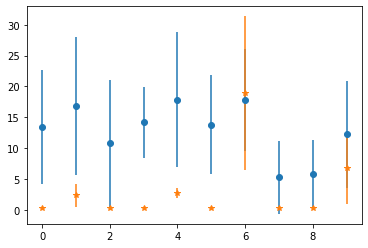

In [64]:
plt.errorbar(x1, y1, e1, linestyle='None', marker='o')
plt.errorbar(x2, y2, e2, linestyle='None', marker='*')
plt.savefig('synthetic_problem.png')

In [36]:
df[(df["M"]==1) & (df["r1"]==55746)& (df["mdf"]==False)]

,m,n,c,r1,M,r2,mdf,fobj,optiter,solveriter,time,scc
362,10,15,1,55746,1,1760134976,False,0.17,67.0,0.0,8.746915,[9]
366,10,15,1,55746,1,1170534942,False,3490.48,165.0,0.0,12.108873,[9]
370,10,15,1,55746,1,317660153,False,1.11,89.0,0.0,12.902382,[9]
374,10,15,1,55746,1,116244473,False,5.02,28.0,0.0,4.209495,[9]
378,10,15,1,55746,1,1617120057,False,1.17,328.0,0.0,36.794137,[9]
382,10,15,1,55746,1,2106555451,False,0.99,81.0,0.0,11.854745,[9]
386,10,15,1,55746,1,1097125525,False,949.85,188.0,0.0,10.611798,[9]
390,10,15,1,55746,1,1446720800,False,0.00,47.0,0.0,6.195764,[9]
394,10,15,1,55746,1,1094134074,False,0.15,75.0,0.0,10.883196,[9]
398,10,15,1,55746,1,1248920238,False,1.00,181.0,0.0,20.326621,[9]


In [31]:
df[(df["M"]==1) & (df["r1"]==53298)& (df["mdf"]==False)]

,m,n,c,r1,M,r2,mdf,fobj,optiter,solveriter,time,scc
2,10,15,1,53298,1,669652944,False,3.610644e+06,110.0,0.0,6.300456,[6]
6,10,15,1,53298,1,535214420,False,3.330000e+00,95.0,0.0,11.421888,[6]
10,10,15,1,53298,1,2037209175,False,2.201920e+03,170.0,0.0,12.335021,[6]
14,10,15,1,53298,1,1767258089,False,2.230540e+03,333.0,0.0,19.995749,[6]
18,10,15,1,53298,1,309580411,False,1.000000e+00,308.0,0.0,31.906136,[6]
22,10,15,1,53298,1,74845286,False,8.800000e-01,72.0,0.0,7.781133,[6]
26,10,15,1,53298,1,2041105245,False,0.000000e+00,163.0,0.0,16.160997,[6]
30,10,15,1,53298,1,1621709875,False,9.344526e+04,58.0,0.0,5.275213,[6]
34,10,15,1,53298,1,1099128569,False,1.052980e+04,31.0,0.0,2.560941,[6]
38,10,15,1,53298,1,1016164991,False,4.596900e+15,169.0,0.0,8.555681,[6]


In [33]:
df[(df["M"]==2) & (df["r1"]==53298)& (df["mdf"]==False)]

,m,n,c,r1,M,r2,mdf,fobj,optiter,solveriter,time,scc
0,10,15,1,53298,2,669652944,False,2.500000e+01,46.0,0.0,3.160977,[2]
4,10,15,1,53298,2,535214420,False,0.000000e+00,9.0,0.0,0.907574,[2]
8,10,15,1,53298,2,2037209175,False,4.825698e+11,114.0,0.0,7.680080,[2]
12,10,15,1,53298,2,1767258089,False,1.100000e-01,55.0,0.0,4.521861,[2]
16,10,15,1,53298,2,309580411,False,2.500000e-01,70.0,0.0,5.907766,[2]
20,10,15,1,53298,2,74845286,False,0.000000e+00,13.0,0.0,1.691943,[2]
24,10,15,1,53298,2,2041105245,False,2.900000e-01,21.0,0.0,2.660893,[2]
28,10,15,1,53298,2,1621709875,False,2.238350e+06,208.0,0.0,18.202569,[2]
32,10,15,1,53298,2,1099128569,False,1.444000e+01,165.0,0.0,15.413010,[2]
36,10,15,1,53298,2,1016164991,False,5.864375e+12,86.0,0.0,7.591239,[2]


In [89]:
df.iloc[0:50]

,m,n,c,r1,M,r2,mdf,fobj,optiter,solveriter,time,scc
0,10,15,1,53298,2,669652944,False,2.500000e+01,56.0,0.0,3.378072,[2]
1,10,15,1,53298,2,669652944,True,0.000000e+00,4.0,804.0,20.975636,[2]
2,10,15,1,53298,1,669652944,False,2.386299e+04,74.0,0.0,6.074229,[6]
3,10,15,1,53298,1,669652944,True,0.000000e+00,4.0,804.0,86.731645,[6]
4,10,15,1,53298,2,535214420,False,0.000000e+00,9.0,0.0,0.923307,[2]
5,10,15,1,53298,2,535214420,True,0.000000e+00,4.0,14.0,0.591746,[2]
6,10,15,1,53298,1,535214420,False,3.330000e+00,101.0,0.0,12.000775,[6]
7,10,15,1,53298,1,535214420,True,0.000000e+00,4.0,538.0,56.705762,[6]
8,10,15,1,53298,2,2037209175,False,8.869529e+12,74.0,0.0,6.597935,[2]
9,10,15,1,53298,2,2037209175,True,9.999000e+03,NaN,NaN,NaN,[2]


In [46]:
df.iloc[0:10]

,m,n,c,r1,M,r2,mdf,fobj,niter,scc
0,10,15,1,53298,2,669652944,False,2.500000e+01,0.0,[2]
1,10,15,1,53298,2,669652944,True,0.000000e+00,804.0,[2]
2,10,15,1,53298,1,669652944,False,3.723109e+05,0.0,[6]
3,10,15,1,53298,1,669652944,True,0.000000e+00,804.0,[6]
4,10,15,1,53298,2,535214420,False,0.000000e+00,0.0,[2]
5,10,15,1,53298,2,535214420,True,0.000000e+00,14.0,[2]
6,10,15,1,53298,1,535214420,False,3.330000e+00,0.0,[6]
7,10,15,1,53298,1,535214420,True,0.000000e+00,428.0,[6]
8,10,15,1,53298,2,2037209175,False,8.869529e+12,0.0,[2]
9,10,15,1,53298,2,2037209175,True,9.999000e+03,True,[2]


In [24]:
df.iloc[0:10]

,m,n,c,r1,M,r2,mdf,fobj,niter,scc
0,10,15,1,53298,2,669652944,False,1.26,0.0,[2]
1,10,15,1,53298,2,669652944,True,9999.00,True,[2]
2,10,15,1,53298,1,669652944,False,1.26,0,[6]
3,10,15,1,53298,1,669652944,True,9999.00,True,[6]
4,10,15,1,53298,2,535214420,False,1.26,0,[2]
5,10,15,1,53298,2,535214420,True,9999.00,True,[2]
6,10,15,1,53298,1,535214420,False,1.26,0,[6]
7,10,15,1,53298,1,535214420,True,9999.00,True,[6]
8,10,15,1,53298,2,2037209175,False,1.26,0,[2]
9,10,15,1,53298,2,2037209175,True,9999.00,True,[2]


In [31]:
sum(df[(df["M"]==1) & (df["r1"]==53298) & (df["mdf"]==True)]['niter']>=0.1)

10

In [34]:
randstruct

defaultdict(list,
            {(10, 15, 1): [55746,
              41743,
              33497,
              17680,
              20173,
              2685,
              4930,
              1083,
              11486,
              53298]})

In [61]:
df[(df["M"]==2) & (df["r1"]==20173)& (df["mdf"]==True)]

,m,n,c,r1,M,r2,mdf,fobj,niter,scc
201,10,15,1,20173,2,2082898964,True,0.0,15,[2]
205,10,15,1,20173,2,692725761,True,0.0,21,[2]
209,10,15,1,20173,2,344997561,True,9999.0,True,[2]
213,10,15,1,20173,2,1558804748,True,0.0,804,[2]
217,10,15,1,20173,2,594619332,True,0.0,7,[2]
221,10,15,1,20173,2,1986274268,True,0.0,725,[2]
225,10,15,1,20173,2,1162275822,True,0.0,804,[2]
229,10,15,1,20173,2,629526661,True,0.0,475,[2]
233,10,15,1,20173,2,1556474546,True,0.0,15,[2]
237,10,15,1,20173,2,197792239,True,0.0,217,[2]


In [50]:
df

,m,n,c,r1,M,r2,mdf,fobj,niter,scc
0,10,15,1,53298,2,669652944,False,0.0,0.0,[2]
1,10,15,1,53298,2,669652944,True,0.0,804.0,[2]
2,10,15,1,53298,1,669652944,False,0.0,0.0,[6]
3,10,15,1,53298,1,669652944,True,9999.0,True,[6]
4,10,15,1,53298,2,535214420,False,0.0,0,[2]
...,...,...,...,...,...,...,...,...,...,...
395,10,15,1,55746,1,1094134074,True,0.0,264,[9]
396,10,15,1,55746,2,1248920238,False,0.0,0,[]
397,10,15,1,55746,2,1248920238,True,0.0,0,[]
398,10,15,1,55746,1,1248920238,False,0.0,0,[9]


In [44]:
elt = df.iloc[10]
kwargs = {key:var for key,var in elt.items() if key not in ['fobj', 'niter', 'scc']}
inputids, var_mapping, edges, tree, components = get_mdaoprobargs(outsets, eqvs, **kwargs)

In [45]:
components

[((11, 0), 0, (None,), '-0.1*x_0*x_11 + 0.3'),
 ((3, 14, 8, 5, 10), 1, (None,), '-0.6*x_10*x_3*x_5 - 0.4*x_14*x_8 - 0.4'),
 ((2, 6), 2, (None,), '-0.9*x_2*x_6 + 0.2'),
 ((11, 13, 4, 12), 3, (None,), '-0.2*x_11*x_13 - 0.5*x_12*x_4 - 0.3'),
 ((11, 0, 12), 4, (None,), '0.3*x_0*x_11*x_12 + 0.8'),
 ((11, 7, 8, 13), 5, (None,), '0.7*x_11*x_13*x_8 - 0.1*x_7 - 0.2'),
 ((3, 4), 6, (None,), '-0.4*x_3*x_4 - 0.9'),
 ((0, 4, 7, 8, 10), 7, (None,), '0.4*x_0*x_10*x_8 - 0.2*x_4*x_7 + 0.8'),
 ((7, 9), 8, (None,), '0.9*x_7*x_9 - 0.9'),
 ((11, 0, 4, 12), 9, (None,), '-0.5*x_0*x_12 + 0.3*x_11*x_4 - 0.6'),
 ((0,), 0, (11,), '3.0/x_0'),
 ((3, 8, 5, 10), 1, (14,), '-(1.5*x_10*x_3*x_5 + 1.0)/x_8'),
 ((2,), 2, (6,), '0.222222222222222/x_2'),
 ((11, 4, 12), 3, (13,), '-(2.5*x_12*x_4 + 1.5)/x_11'),
 ((11, 12), 4, (0,), '-2.66666666666667/(x_11*x_12)'),
 ((11, 8, 13), 5, (7,), '7.0*x_11*x_13*x_8 - 2.0'),
 ((4,), 6, (3,), '-2.25/x_4'),
 ((7, 8, 10, 0), 7, (4,), '(2.0*x_0*x_10*x_8 + 4.0)/x_7'),
 ((7,), 8, (9,), '1/

In [95]:
inputids, var_mapping, edges, tree, components = generate_prob(outsets, eqvs, **df.iloc[10])
prob,formulation = generate_mdao_prob(inputids, var_mapping, edges, tree, components)

In [96]:
formulation[1]

(OrderedDict([(3, 2), (1, 2), ('obj', 1), (0, 1), (2, 1), (4, 1)]),
 {2: 1},
 {8: 1, 1: 1, 3: 1, 6: 1, 7: 2, 5: 2})

In [97]:
#prob.set_solver_print(-1)

In [98]:
prob.run_driver();


s_1.s_2
NL: Newton Converged in 7 iterations

s_1.s_2
NL: Newton Converged in 1 iterations

s_1.s_2
NL: Newton Converged in 5 iterations

s_1.s_2
NL: Newton Converged in 4 iterations


In [99]:
#prob.model.s_1.s_2.iter_count_apply

In [100]:
prob.driver.result.fun

array([0.])

In [212]:
components, newidx = add_obj(inputids, var_mapping, edges, tree, components)
solvers_options = {1: {'type': OPT}, 2:{'maxiter':100}}
comp_options = {newidx:OBJ}
var_options = {}
nodetyperepr = {VAR: 'x{}', COMP: 'f_{}', SOLVER: 's_{}'}
#prob, mdao_in, groups = nestedform_to_mdao(edges, tree, components, solvers_options, comp_options, var_options, nodetyperepr, mdf=True)

In [171]:
components

[((1, 5, 0, 6, 2), 0, (None,), '0.4*x_0*x_2*x_6 - 0.5*x_1*x_5 + 0.1'),
 ((8, 5), 1, (None,), '0.6*x_5*x_8 + 0.5'),
 ((8, 6, 5, 0), 2, (None,), '0.3*x_0*x_6 + 0.8*x_5*x_8 - 0.2'),
 ((6, 4), 3, (None,), '-0.2*x_4*x_6 - 0.3'),
 ((1, 2), 4, (None,), '1.0*x_1*x_2 + 0.4'),
 ((5, 1, 2, 0), 0, (6,), '(1.25*x_1*x_5 - 0.25)/(x_0*x_2)'),
 ((5,), 1, (8,), '-0.833333333333333/x_5'),
 ((8, 6, 5), 2, (0,), '(-2.66666666666667*x_5*x_8 + 0.666666666666667)/x_6'),
 ((6,), 3, (4,), '-1.5/x_6'),
 ((1,), 4, (2,), '-0.4/x_1'),
 ((1, 5), 'obj', (None,), '(x_1 - 1)**2 + (x_5 - 1)**2')]

In [57]:
eqv = eqvs[(5,10,1,5546)]

In [58]:
eqv

{0: (6, 12, 13, 7), 1: (6, 10, 8), 2: (9, 13, 14, 5), 3: (6, 9, 13), 4: (12,)}

In [59]:
outset = outsets[(5,10,1,5546,2)]

In [60]:
outset

{0: 2, 1: 3, 2: 0, 3: 8, 4: 7}

In [56]:
args=df.iloc[0:2]
args

,m,n,c,r1,M,r2,mdf
0,5,10,1,5546,2,74845286,False
1,5,10,1,5546,2,74845286,True


# -----

In [ ]:
def run_incidence_case(eqv, output_set, n_eqs, inputids):
    polynomials, var_mapping, edges, tree, components = generate_random_polynomials(eqv, output_set, n_eqs)
    optimal_formulation(eqv, output_set)
    generate_mdao_prob(inputids, var_mapping, edges, tree, components):

In [143]:
_, edges_original = bipartite_repr(eqv)
eqs=direct_eqs(eqv, output_set)
avrs = getallvars(eqs, sympy=False)
eqns = eqs.keys()
graph_edges = invert_edges(edges_original)

In [144]:
maxl, m = min_max_scc(graph_edges, avrs, eqns, len(eqns))

In [145]:
maxl

3.0

In [146]:
output_set2 = dict(outset_from_solution(m))

In [147]:
output_set2 = {key:var-n_eqs for key,var in output_set2.items()}

In [148]:
components2 = directed_poly_executables(var_mapping, polynomials, output_set2)

In [149]:
edges2, tree2 = eqv_to_edges_tree(eqv, output_set2, n_eqs)

In [150]:
sources(*edges_to_Ein_Eout(edges2))

{0, 1, 6, 8, 9}

In [151]:
inputids = sources(*edges_to_Ein_Eout(edges2))

In [153]:
components1 = add_obj(inputids, var_mapping, edges, tree, components)

In [154]:
dv = nested_sources(edges, tree, 1)
for elt in dv:
    tree[2][elt] = 1

In [155]:
components22 = add_obj(inputids, var_mapping, edges2, tree2, components2)

In [156]:
dv = nested_sources(edges2, tree2, 1)
for elt in dv:
    tree2[2][elt] = 1

In [157]:
dv

{0, 1, 6, 8, 9}

In [158]:
# from graphutils import flat_graph_formulation, root_solver
# from operators import sort_scc, reorder_merge_solve
# from workflow import order_from_tree, mdao_workflow, default_solver_options
# G = flat_graph_formulation(*edges)
# merge_order = sort_scc(G)
# merge_parent = root_solver(tree) # all merged components will have this solver as the parent
# ordered_edges, ordered_tree = reorder_merge_solve(edges, tree, merge_order, merge_parent, False)
# sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
# solvers_options = default_solver_options(ordered_tree, solvers_options)
# wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)

In [159]:
solvers_options = {1: {'type': OPT}, 2:{'maxiter':100}}
comp_options = {newidx:OBJ}
var_options = {}

In [164]:
nodetyperepr = {VAR: 'x{}', COMP: 'f_{}', SOLVER: 's_{}'}
prob, mdao_in, groups = nestedform_to_mdao(edges2, tree2, components22, solvers_options, comp_options, var_options, nodetyperepr, mdf=True)

In [165]:
om.n2(prob.model)

In [166]:
for elt in mdao_in:
    prob.set_val(elt, 0.1)

In [167]:
prob.run_driver();


s_1.s_2
NL: Newton Converged in 1 iterations

s_1.s_2
NL: Newton Converged in 0 iterations

s_1.s_2
NL: Newton Converged in 1 iterations

s_1.s_2
NL: Newton Converged in 1 iterations
Optimization terminated successfully    (Exit mode 0)
            Current function value: [0.]
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2
Optimization Complete
-----------------------------------


In [27]:
prob.model.list_outputs();

11 Explicit Output(s) in 'model'

varname   val          
--------  -------------
inp
  x3      [1.]         
  x5      [1.]         
  x6      [1.]         
  x7      [1.]         
  x9      [1.]         
s_1
  f_2
    x2    [-0.33333333]
  f_5
    obj5  [0.]         
  f_1
    x4    [-1.66666667]
  f_3
    x0    [1.26666667] 
  f_0
    x8    [-0.24444444]
  f_4
    x1    [7.07792208] 


0 Implicit Output(s) in 'model'




In [39]:
merge_order

[{f_0}, {f_3}, {f_1}, {f_2, f_4}]

In [42]:
sources(*edges_to_Ein_Eout(edges))

{1, 4, 5, 6}

In [10]:
output_set2

{0: 9, 1: 6, 2: 10, 3: 13, 4: 12}

In [27]:
maxl

2.0

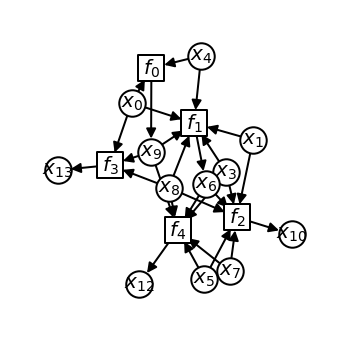

In [26]:
from graphutils import flat_graph_formulation, draw_graph_graphical_props
G = flat_graph_formulation(*edges2, nodetyperepr=default_nodetyperepr)
draw_graph_graphical_props(G, {}, prog='neato', figsize=(6,6))

In [16]:
polynomials

{0: 0.6*x_1*x_3*x_4 + 0.4,
 1: -0.5*x_0 + 0.9*x_1*x_3 + 0.3*x_2*x_4 + 0.9,
 2: 0.4*x_0*x_2 - 0.3*x_1*x_3*x_4 + 0.5}

In [11]:
output_set = {key:var-n_eqs for key,var in output_set.items()}
edges, tree= eqv_to_edges_tree(eqv, output_set, n_eqs)

In [12]:
rng = np.random.default_rng(12345)

In [13]:
nodetyperepr = {VAR: '{}', COMP: 'f_{}', SOLVER: 's_{}'}
solvers_options = {1: {'type': OPT}}
comp_options = {3:OBJ, 4:NEQ, 5:NEQ}
var_options = {}

In [ ]:
prob, mdao_in, groups = nestedform_to_mdao(edges, tree, components, solvers_options, comp_options, var_options, nodetyperepr, mdf=True)